In [1]:
%load_ext autoreload
%autoreload 2

# Tutorial: analyzing finite-volume ocean model budgets with `xbudget`

This tutorial shows how to use `xbudget` to close and manipulate mass and tracer budgets in finite-volume. 

### Load diagnostics

In [2]:
import xarray as xr
import xgcm
import matplotlib.pyplot as plt

In [3]:
gridname = 'natv' #   choose from ['natv', 'rho2', 'zstr']
dt = 'monthly' #       choose from ['monthly', 'daily', 'hourly']

In [4]:
# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "190*"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
    
#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()
ds = ds.assign_coords({"areacello": xr.DataArray(ocean_grid.areacello.values, dims=("yh", "xh"))})

In [5]:
# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}
grid = xgcm.Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

### Load budget metadata

In [6]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6").copy()

We load in the file `xbudget/conventions/MOM6.yaml`, which comprehensively details the mass, heat, and salt budgets in MOM6, and how they can be evaluated using various combinations of diagnostics. In MOM6, most mass and tracer diagnostics are output as thickness tendencies and thickness-weighted tracer tendencies, respectively, and must be converted into density-weighted integrals over a finite-volume cell by multiplying by a seawater density and grid cell area.

For example, consider the structure of the heat budget:

In [7]:
import json
print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": {
                "product": {
                    "area": "areacello",
                    "tracer_content_tendency_per_unit_area": "opottemptend",
                    "var": null
                },
                "var": null
            },
            "advection": {
                "sum": {
                    "interfacial": {
                        "product": {
                            "area": "areacello",
                            "sign": -1.0,
                            "tracer_content_tendency_per_unit_area": "Th_tendency_vert_remap",
                            "var": null
                        },
                        "var": null
                    },
                    "lateral": {
                        "product": {
                            "area": "areacello",
                            "sign": -1.0,
                            "tracer_content_tendency_per_unit_area": 

The `var: null` entries in the dictionary denote where diagnostics are not directly available. In many cases, however, they can be reconstructed by taking the sum or product of available diagnostics.

We can use the `xbudget.collect_budgets` function to leverage the information in this metadata dictionary to fill in all of these gaps in the budget.

In [8]:
xbudget.collect_budgets(grid, budgets_dict)

/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/work/hfd/.conda/envs/xwmb/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


 All of these reconstructed budget terms are also automatically (and lazily) added to the original dataset with a straight-forward naming convention, so they can be used directly to evaluate the budget.

In [9]:
import json
print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": {
                "product": {
                    "area": "areacello",
                    "tracer_content_tendency_per_unit_area": "opottemptend",
                    "var": "heat_lhs_sum_Eulerian_tendency_product"
                },
                "var": "heat_lhs_sum_Eulerian_tendency"
            },
            "advection": {
                "sum": {
                    "interfacial": {
                        "product": {
                            "area": "areacello",
                            "sign": -1.0,
                            "tracer_content_tendency_per_unit_area": "Th_tendency_vert_remap",
                            "var": "heat_lhs_sum_advection_sum_interfacial_product"
                        },
                        "var": "heat_lhs_sum_advection_sum_interfacial"
                    },
                    "lateral": {
                        "product": {
                

Because searching through this data structure by eye can be tedious, we include helpers functions to help retrieve the variable name corresponding to each term in the budget.

In [10]:
from xbudget import get_vars
grid._ds[get_vars(budgets_dict, "heat_lhs_sum_advection")['var']]

<xarray.DataArray 'heat_lhs_sum_advection' (time: 13, zl: 75, yh: 105, xh: 97)>
dask.array<add, shape=(13, 75, 105, 97), dtype=float32, chunksize=(1, 75, 105, 97), chunktype=numpy.ndarray>
Coordinates:
  * xh         (xh) float64 6.125 6.375 6.625 6.875 ... 29.38 29.62 29.88 30.12
  * yh         (yh) float64 53.01 53.16 53.31 53.46 ... 65.31 65.39 65.48 65.56
  * time       (time) object 1900-01-16 12:00:00 ... 1901-01-16 12:00:00
  * zl         (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
    areacello  (yh, xh) float32 2.806e+08 2.806e+08 ... 7.357e+07 7.306e+07
Attributes:
    provenance:  heat_lhs_sum_advection_sum

If the variable is not immediately available as a diagnostic–but instead derived from other diagnostics–the `provenance` attribute points to the origin of the variable.

For variables that are the sum or product of other terms, it also returns a list of the variables that feed into the operation:

In [11]:
get_vars(budgets_dict, "heat_lhs_sum_advection_sum")

{'var': 'heat_lhs_sum_advection_sum',
 'sum': ['heat_lhs_sum_advection_sum_lateral',
  'heat_lhs_sum_advection_sum_interfacial']}

The terms from which the variable is derived are not necessarily other `xr.DataArray` objects–they can also be constant numbers.

In [12]:
get_vars(budgets_dict, "heat_lhs_sum_surface_ocean_flux_advective_negative_lhs_product")

{'var': 'heat_lhs_sum_surface_ocean_flux_advective_negative_lhs_product',
 'product': [-1.0,
  3992.0,
  'tos',
  'boundary_forcing_h_tendency',
  1035.0,
  'areacello']}

The `get_vars` functions takes either a string or a list of strings:

In [13]:
get_vars(budgets_dict, ["heat_lhs", "heat_rhs_sum_diffusion_sum", "boundary_forcing_heat_tendency"])

[{'var': 'heat_lhs'},
 {'var': 'heat_rhs_sum_diffusion_sum',
  'sum': ['heat_rhs_sum_diffusion_sum_lateral',
   'heat_rhs_sum_diffusion_sum_interfacial']},
 {'var': 'boundary_forcing_heat_tendency'}]

### Verification that the budgets close

We compare the left-hand-side (LHS) tendency terms against the sum of all of the right-hand-side (RHS) terms. 

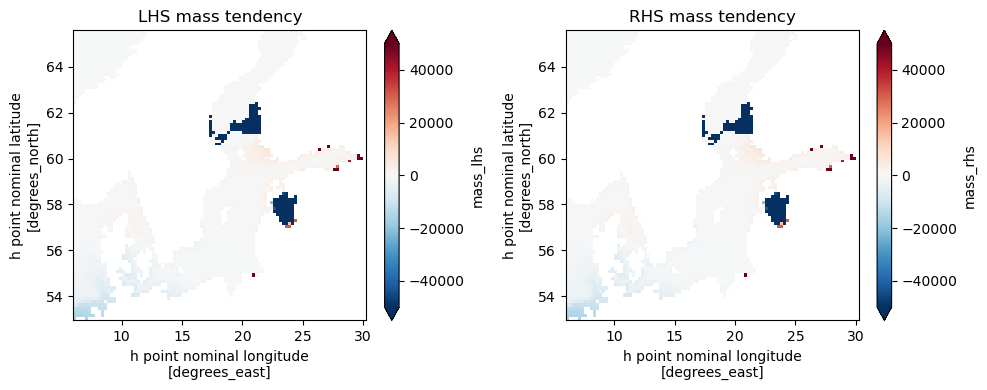

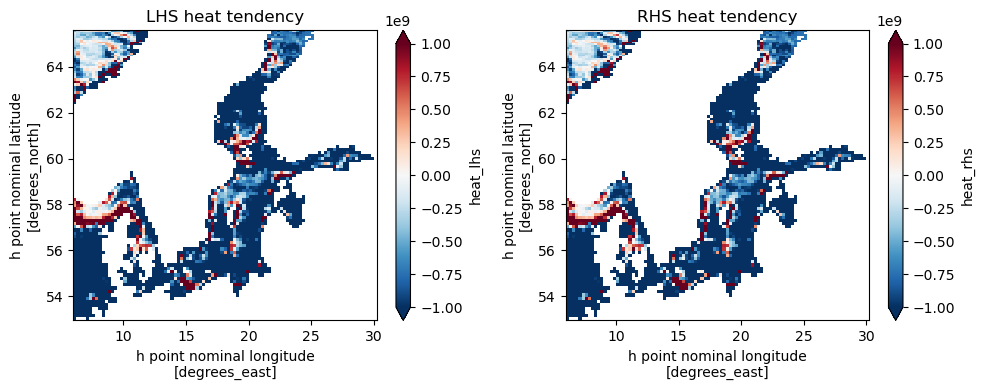

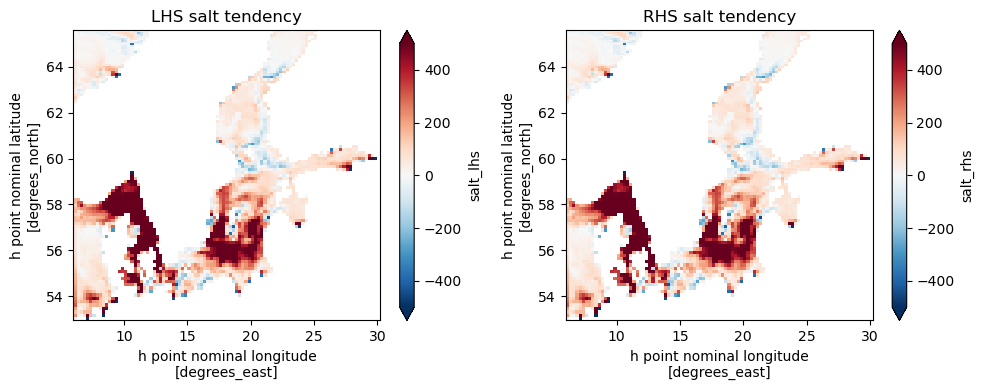

In [14]:
for eq, vmax in zip(["mass", "heat", "salt"], [5.e4, 1e9, 5.e2]):
    plt.figure(figsize=(10, 4))

    plt.subplot(1,2,1)
    pc = grid._ds[get_vars(budgets_dict, f"{eq}_lhs")['var']].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    plt.title(f"LHS {eq} tendency")
    
    plt.subplot(1,2,2)
    pc = grid._ds[get_vars(budgets_dict, f"{eq}_rhs")['var']].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    plt.title(f"RHS {eq} tendency")

    plt.tight_layout()

### Decompose RHS budget terms with `xbudget`

Since the full budget is relatively clunky and can be decomposed in a number of different ways, we include helper functions for collecting all of the high-level terms and optionally dissaggreating terms of interest:

In [15]:
# Default high-level aggregate budget
simple_budgets = xbudget.aggregate(budgets_dict)
simple_budgets

{'mass': {'lambda': 'density',
  'lhs': {'Eulerian_tendency': 'mass_lhs_sum_Eulerian_tendency'},
  'rhs': {'advection': 'mass_rhs_sum_advection',
   'surface_exchange_flux': 'mass_rhs_sum_surface_exchange_flux'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'heat_lhs_sum_Eulerian_tendency',
   'advection': 'heat_lhs_sum_advection',
   'surface_ocean_flux_advective_negative_lhs': 'heat_lhs_sum_surface_ocean_flux_advective_negative_lhs'},
  'rhs': {'diffusion': 'heat_rhs_sum_diffusion',
   'surface_exchange_flux': 'heat_rhs_sum_surface_exchange_flux',
   'surface_ocean_flux_advective_negative_rhs': 'heat_rhs_sum_surface_ocean_flux_advective_negative_rhs',
   'bottom_flux': 'heat_rhs_sum_bottom_flux',
   'frazil_ice': 'heat_rhs_sum_frazil_ice'}},
 'salt': {'lambda': 'so',
  'surface_lambda': 'sos',
  'lhs': {'Eulerian_tendency': 'salt_lhs_sum_Eulerian_tendency',
   'advection': 'salt_lhs_sum_advection',
   'surface_ocean_flux_advective_negative_

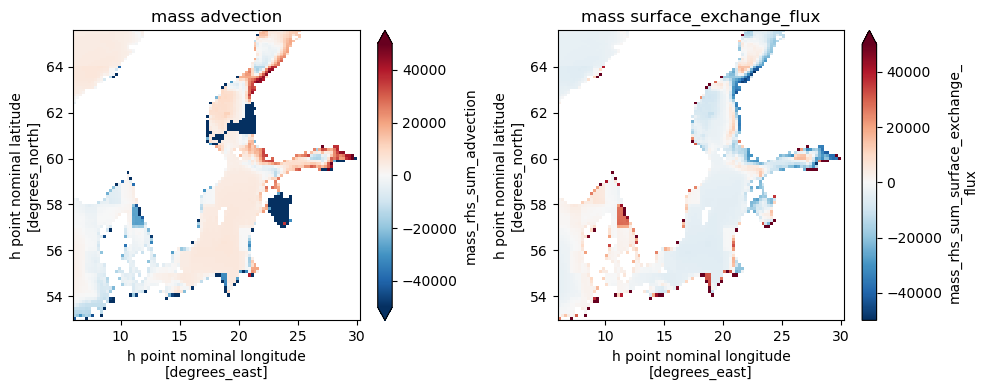

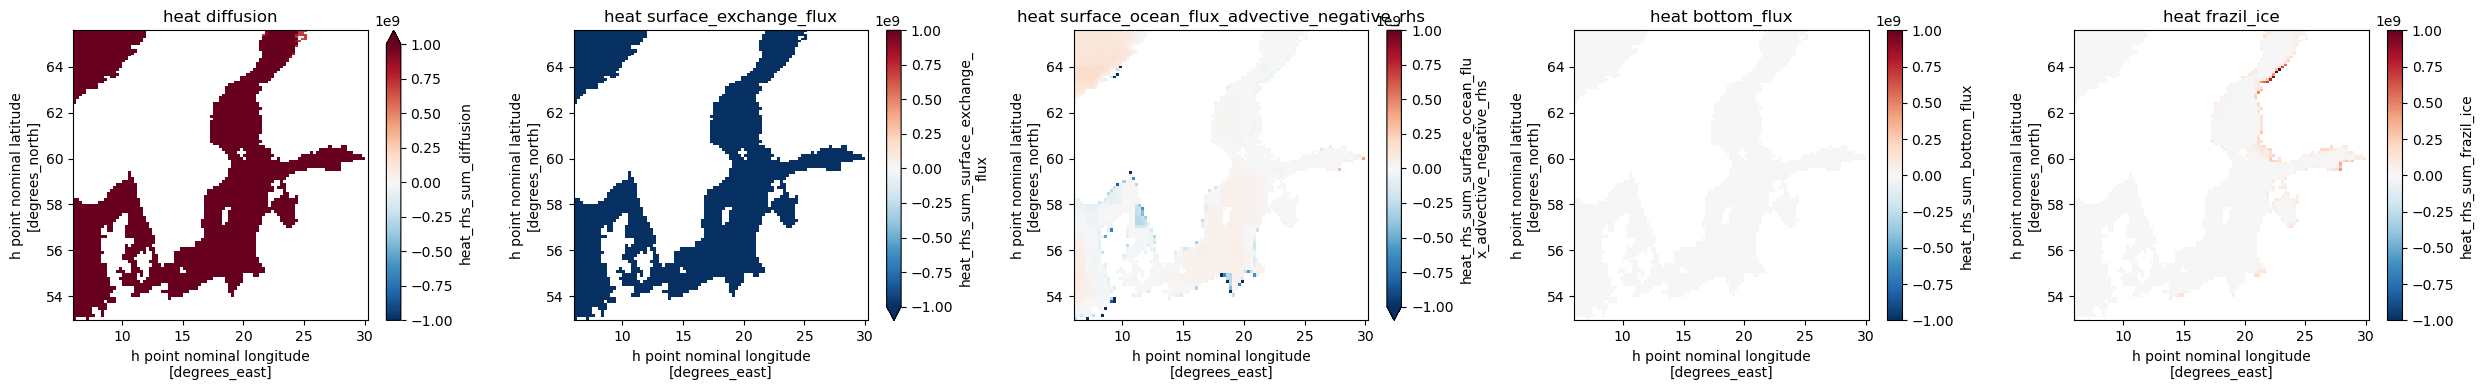

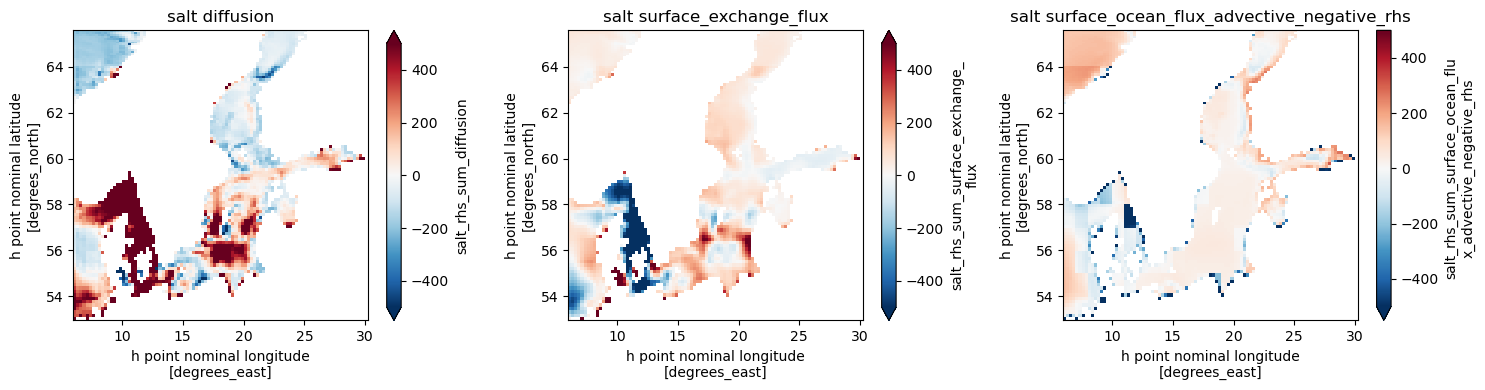

In [16]:
vmax = 1.e-4

for eq, vmax in zip(["mass", "heat", "salt"], [5.e4, 1e9, 5.e2]):
    N = len(simple_budgets[eq]['rhs'])
    plt.figure(figsize=(5*N, 4))
    for i, (k,v) in enumerate(simple_budgets[eq]['rhs'].items(), start=1):
        plt.subplot(1,N, i)
        if "zl" in grid._ds[v].dims:
            grid._ds[v].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        else:
            grid._ds[v].isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        plt.title(f"{eq} {k}")

    plt.tight_layout()

### Custom budget decompositions

Suppose we want to have a better understanding of the processes driving both the `surface_flux` terms and interior `diffusion` terms. We can simply pass the list of these process names to the `decompose` keyword argument. We can also further breakdown the `nonadvective` part of the `surface_flux` term.

In [17]:
decomposed_budgets = xbudget.aggregate(budgets_dict, decompose=["surface_exchange_flux", "nonadvective", "diffusion"])
decomposed_budgets

{'mass': {'lambda': 'density',
  'lhs': {'Eulerian_tendency': 'mass_lhs_sum_Eulerian_tendency'},
  'rhs': {'advection': 'mass_rhs_sum_advection',
   'surface_exchange_flux_rain_and_ice': 'mass_rhs_sum_surface_exchange_flux_sum_rain_and_ice',
   'surface_exchange_flux_snow': 'mass_rhs_sum_surface_exchange_flux_sum_snow',
   'surface_exchange_flux_evaporation': 'mass_rhs_sum_surface_exchange_flux_sum_evaporation',
   'surface_exchange_flux_rivers': 'mass_rhs_sum_surface_exchange_flux_sum_rivers',
   'surface_exchange_flux_icebergs': 'mass_rhs_sum_surface_exchange_flux_sum_icebergs',
   'surface_exchange_flux_virtual_precip_restoring': 'mass_rhs_sum_surface_exchange_flux_sum_virtual_precip_restoring'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'heat_lhs_sum_Eulerian_tendency',
   'advection': 'heat_lhs_sum_advection',
   'surface_ocean_flux_advective_negative_lhs': 'heat_lhs_sum_surface_ocean_flux_advective_negative_lhs'},
  'rhs': {'diffusio

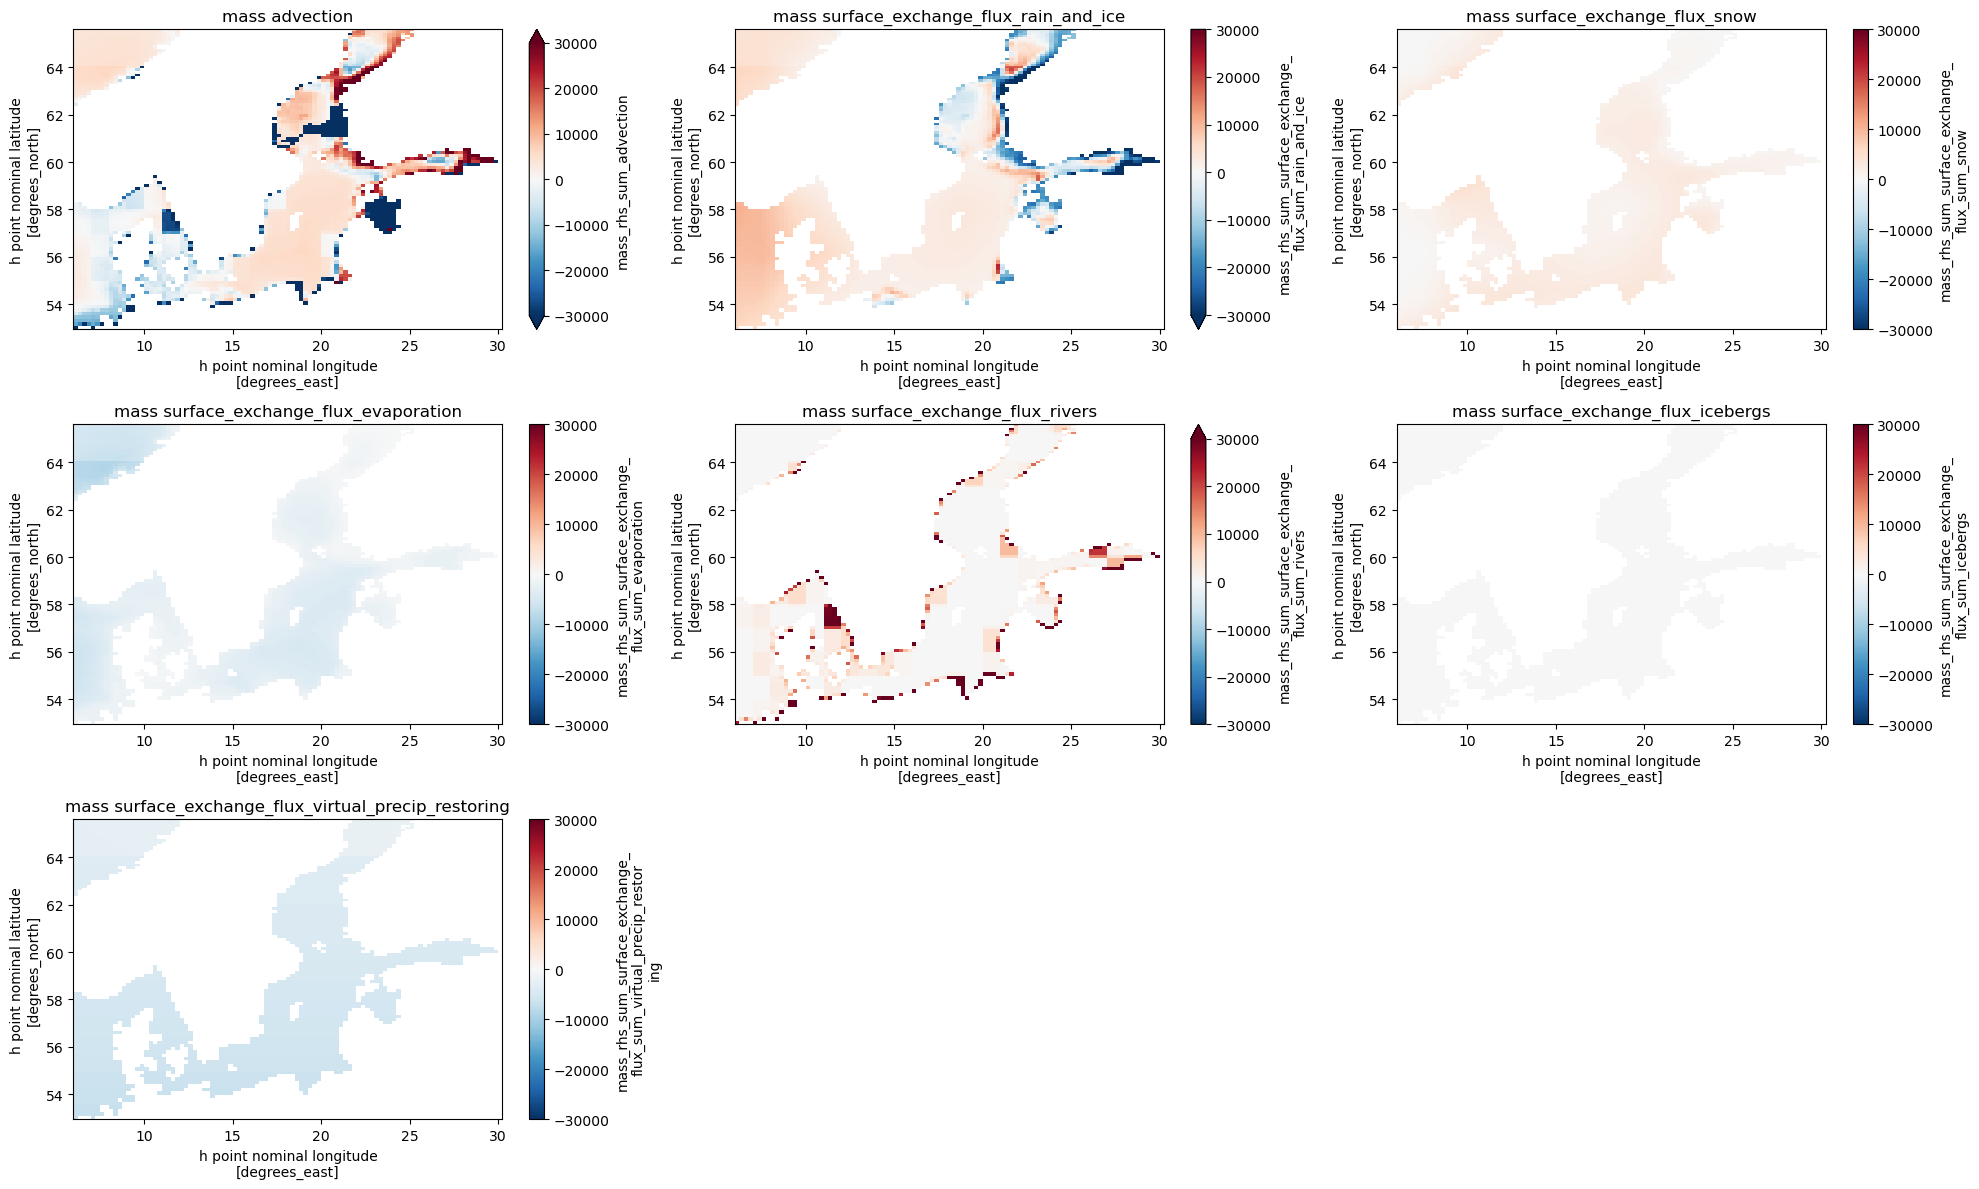

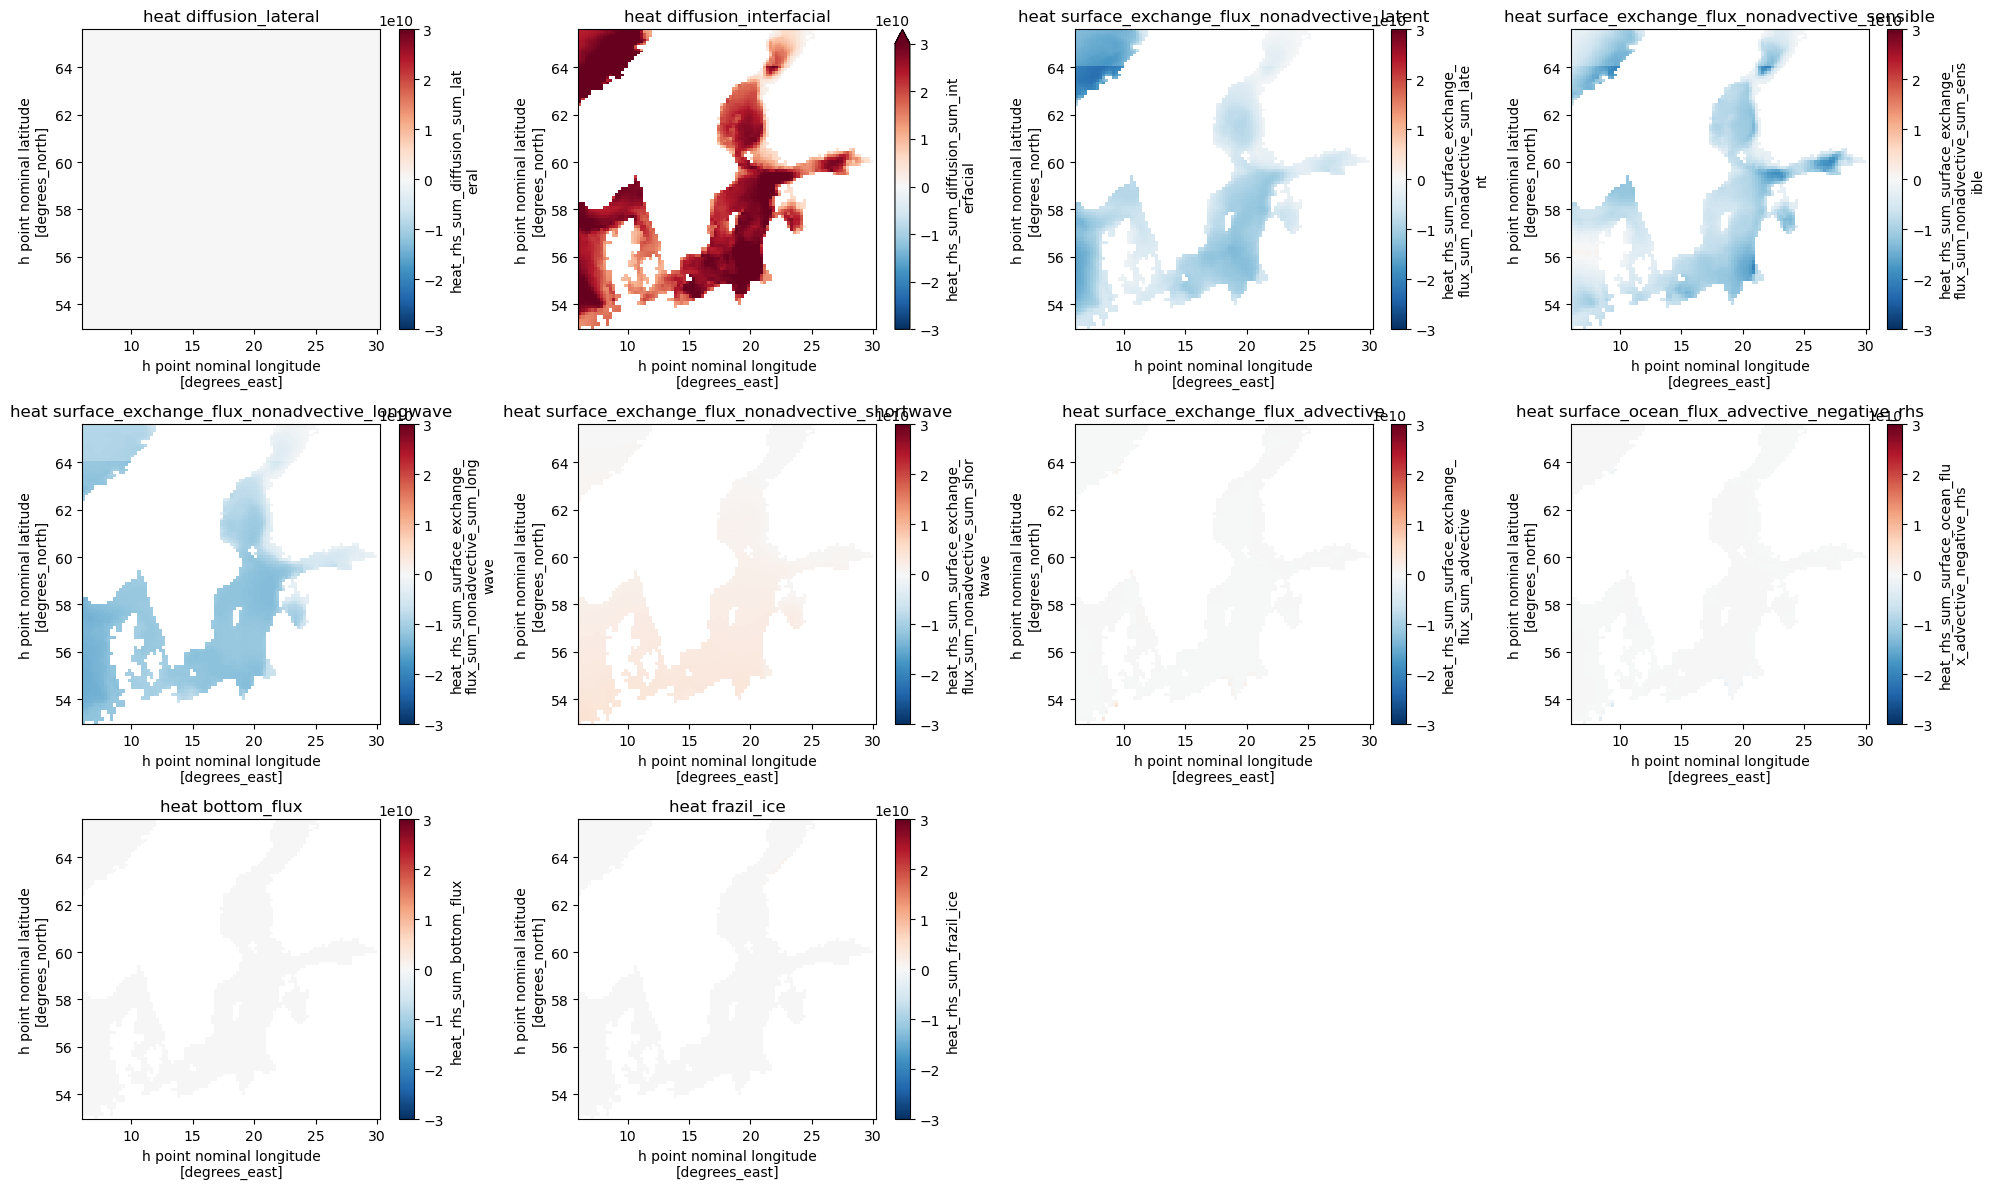

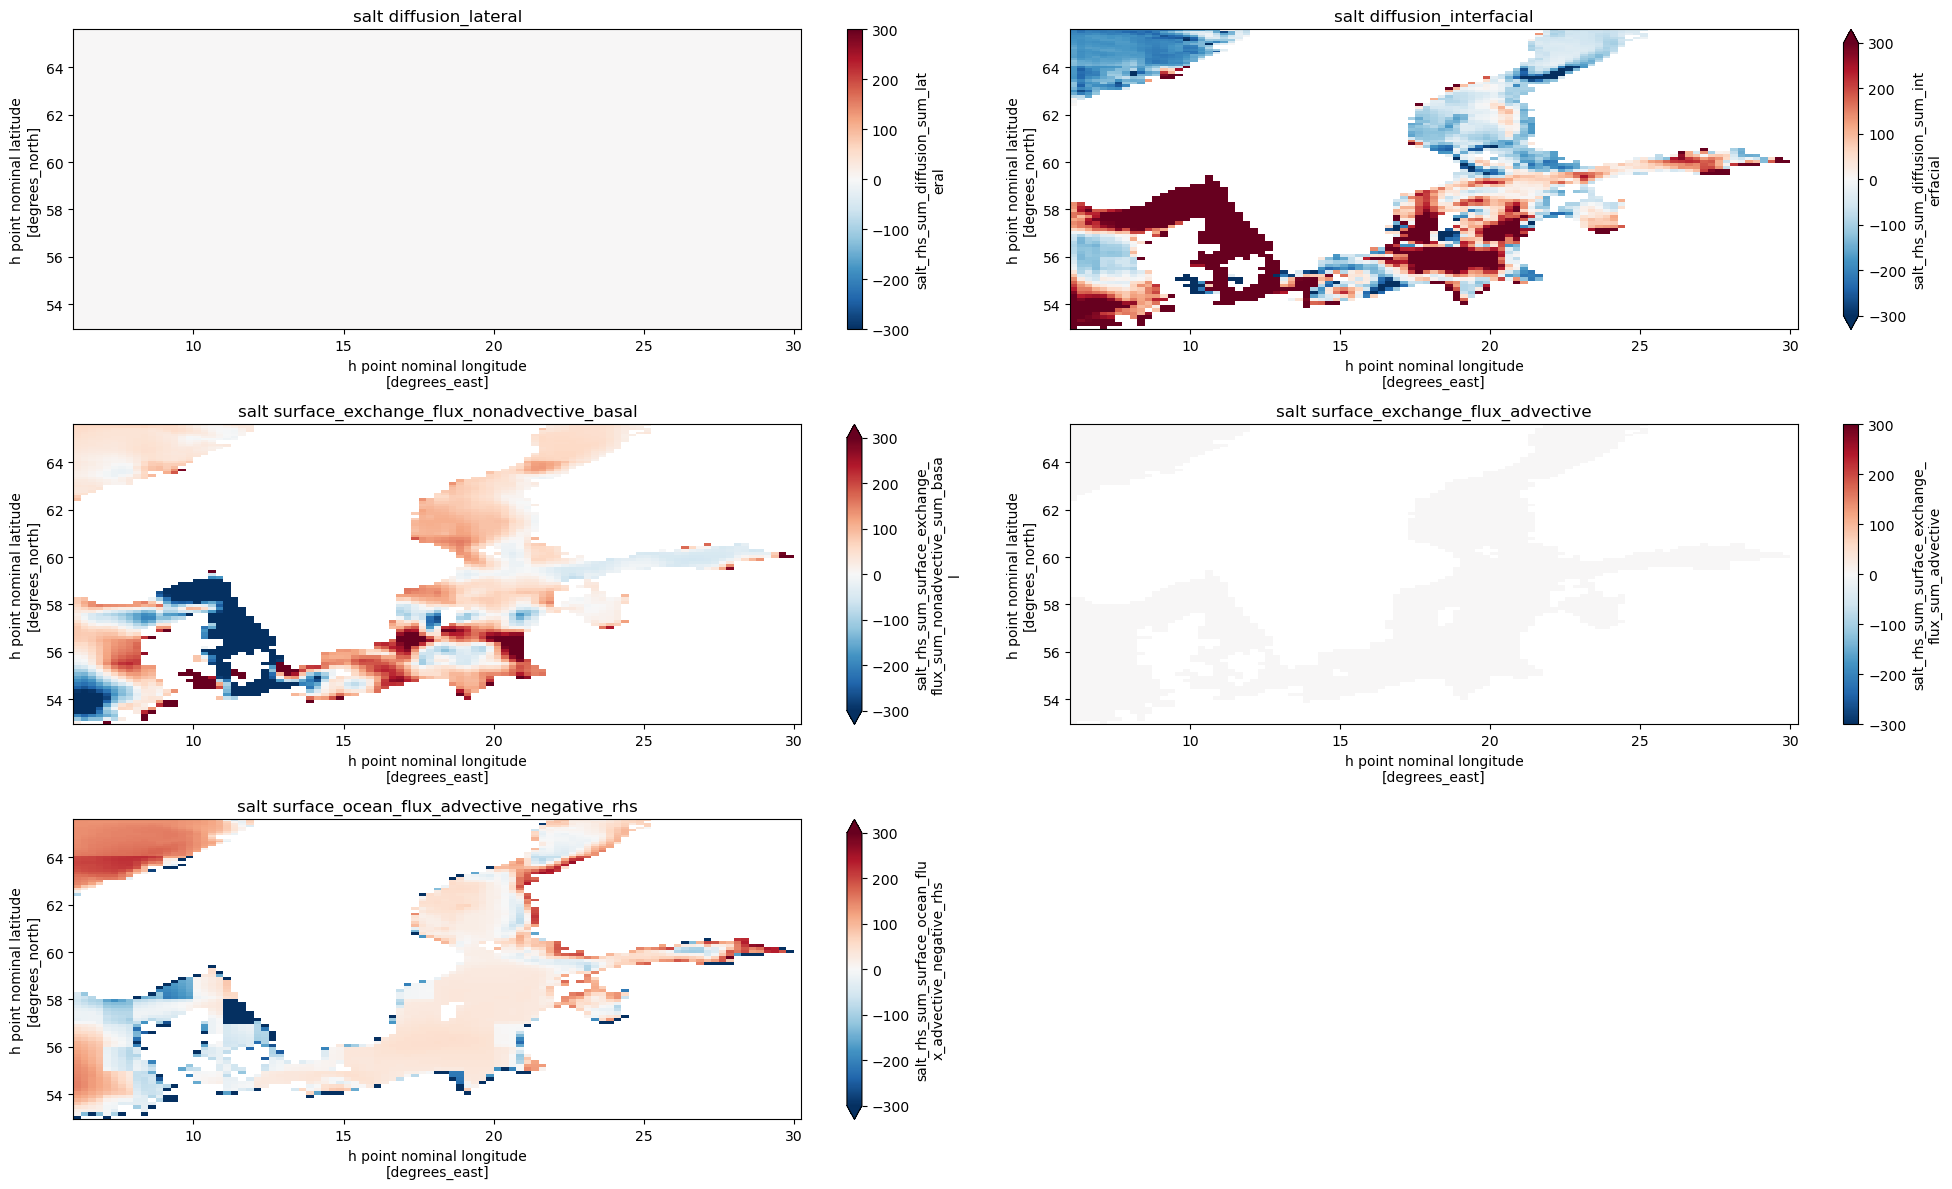

In [18]:
vmax = 1.e-4
import numpy as np

for eq, vmax in zip(["mass", "heat", "salt"], [3.e4, 3e10, 3.e2]):
    plt.figure(figsize=(20, 12))
    for i, (k,v) in enumerate(decomposed_budgets[eq]['rhs'].items(), start=1):
        plt.subplot(3, np.int64(np.ceil(len(decomposed_budgets[eq]['rhs'])/3)), i)
        if "zl" in grid._ds[v].dims:
            grid._ds[v].isel(zl = 0).isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        else:
            grid._ds[v].isel(time=0).plot(vmin=-vmax, vmax=vmax, cmap="RdBu_r")
        plt.title(f"{eq} {k}")

    plt.tight_layout()